In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. 데이터셋 ZIP 파일 경로 및 해제 경로 설정
zip_file_path = '/content/drive/MyDrive/mask rcnn dataset/total-dataset_640.coco-segmentation.zip'
extract_path = '/content/dataset'

In [ ]:
import os
import zipfile

# 2. ZIP 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print('ZIP 파일 해제 완료')

#dataset폴더 만들기
os.makedirs('/content/dataset', exist_ok=True)


ZIP 파일 해제 완료


In [ ]:
# import json

# # 경로 설정
# coco_json_paths = {
#     'train': '/content/dataset/train/_annotations.coco.json',
#     'valid': '/content/dataset/valid/_annotations.coco.json',
#     'test':  '/content/dataset/test/_annotations.coco.json'
# }

# # 변환된 COCO JSON 파일을 저장할 경로
# output_json_paths = {
#     'train': '/content/dataset/train/_annotations_bbox.coco.json',
#     'valid': '/content/dataset/valid/_annotations_bbox.coco.json',
#     'test':  '/content/dataset/test/_annotations_bbox.coco.json'
# }

# # Polygon 데이터를 Bounding Box로 변환하는 함수
# def convert_polygon_to_bbox(coco_json_path, output_json_path):
#     # COCO JSON 파일 불러오기
#     with open(coco_json_path, 'r') as f:
#         coco_data = json.load(f)

#     # 기존 COCO 데이터의 annotations
#     annotations = coco_data['annotations']

#     # 각 annotation을 순회하면서 polygon 데이터를 bbox로 변환
#     for annotation in annotations:
#         if 'segmentation' in annotation and len(annotation['segmentation']) > 0:
#             # segmentation은 폴리곤 좌표들의 리스트로 구성됨 (ex: [[x1, y1, x2, y2, ...]])
#             polygon = annotation['segmentation'][0]

#             # Polygon의 좌표들로부터 Bounding Box 계산
#             x_coords = polygon[0::2]
#             y_coords = polygon[1::2]

#             x_min = min(x_coords)
#             y_min = min(y_coords)
#             x_max = max(x_coords)
#             y_max = max(y_coords)

#             # Bounding Box는 [x_center, y_center, width, height] 형식
#             width = x_max - x_min
#             height = y_max - y_min
#             x_center = x_min + width / 2
#             y_center = y_min + height / 2
#             bbox = [x_center, y_center, width, height]

#             # bbox 항목에 저장
#             annotation['bbox'] = bbox

#     # 새로운 COCO JSON 파일로 저장
#     with open(output_json_path, 'w') as f:
#         json.dump(coco_data, f, indent=4)

#     print(f"Polygon 데이터가 Bounding Box로 변환되었습니다: {output_json_path}")

# # train, valid, test 폴더의 각 coco json 파일에 대해 변환 실행
# for dataset_type, json_path in coco_json_paths.items():
#     output_path = output_json_paths[dataset_type]
#     convert_polygon_to_bbox(json_path, output_path)


In [ ]:
import os
import json
import shutil

dataset = ['train', 'valid', 'test']

for data in dataset:
    # 경로 설정
    folder = f'/content/dataset/{data}'
    images_folder = os.path.join(folder, 'images')
    labels_folder = os.path.join(folder, 'labels')
    coco_json_path = os.path.join(folder, '_annotations.coco.json')

    # images와 labels 폴더 생성
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(labels_folder, exist_ok=True)

    # COCO JSON 파일 불러오기
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # 이미지 파일을 images 폴더로 이동하고 YOLO 포맷 라벨 파일 생성
    for image_info in coco_data['images']:
        image_file_name = image_info['file_name']
        image_id = image_info['id']
        image_width = image_info['width']
        image_height = image_info['height']

        # 원본 이미지 경로와 새로운 images 폴더 내의 경로
        original_image_path = os.path.join(folder, image_file_name)
        new_image_path = os.path.join(images_folder, image_file_name)

        # 이미지 파일을 images 폴더로 이동 (이미 존재하지 않으면 이동)
        if os.path.exists(original_image_path) and not os.path.exists(new_image_path):
            shutil.move(original_image_path, new_image_path)

        # 해당 이미지에 대한 라벨 정보 추출
        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

        # YOLO 라벨 파일 경로 설정
        label_file_name = os.path.splitext(image_file_name)[0] + '.txt'
        label_file_path = os.path.join(labels_folder, label_file_name)

        # YOLO 라벨 파일 작성
        with open(label_file_path, 'w') as label_file:
            for ann in annotations:
                class_id = ann['category_id'] - 1  # YOLO는 class_id를 0부터 시작
                bbox = ann['bbox']  # COCO 포맷: [x_min, y_min, width, height]

                # COCO의 bbox(x_min, y_min, width, height)를 YOLO 형식(x_center, y_center, width, height)로 변환
                x_min, y_min, bbox_width, bbox_height = bbox
                x_center = (x_min + bbox_width / 2) / image_width
                y_center = (y_min + bbox_height / 2) / image_height
                width = bbox_width / image_width
                height = bbox_height / image_height

                # YOLO format: class_id, x_center, y_center, width, height (이미지 크기로 정규화됨)
                label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    print(f"{data}: 이미지 파일을 images 폴더 안으로 이동시키고 labels 폴더안에 YOLO 포맷 라벨 txt 파일을 생성했습니다.")


train: 이미지 파일을 images 폴더 안으로 이동시키고 labels 폴더안에 YOLO 포맷 라벨 txt 파일을 생성했습니다.
valid: 이미지 파일을 images 폴더 안으로 이동시키고 labels 폴더안에 YOLO 포맷 라벨 txt 파일을 생성했습니다.
test: 이미지 파일을 images 폴더 안으로 이동시키고 labels 폴더안에 YOLO 포맷 라벨 txt 파일을 생성했습니다.


In [ ]:
import os

# 경로 설정
dataset_dir = '/content/dataset'

# 폴더 리스트
folders = ['train', 'valid', 'test']

# 각 폴더의 labels 폴더 안에 있는 txt 파일 개수 세기
for folder in folders:
    labels_dir = os.path.join(dataset_dir, folder, 'labels')
    txt_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    print(f"{folder} 폴더의 txt 파일 개수: {len(txt_files)}")


train 폴더의 txt 파일 개수: 4801
valid 폴더의 txt 파일 개수: 1363
test 폴더의 txt 파일 개수: 684


In [ ]:
# # 경로 설정
# valid_folder = '/content/dataset/valid'
# images_folder = os.path.join(valid_folder, 'images')
# labels_folder = os.path.join(valid_folder, 'labels')
# coco_json_path = os.path.join(valid_folder, '_annotations.coco.json')

# # images와 labels 폴더 생성
# os.makedirs(images_folder, exist_ok=True)
# os.makedirs(labels_folder, exist_ok=True)

# # COCO JSON 파일 불러오기
# with open(coco_json_path, 'r') as f:
#     coco_data = json.load(f)

# # 이미지 파일을 images 폴더로 이동하고 YOLO 포맷 라벨 파일 생성
# for image_info in coco_data['images']:
#     image_file_name = image_info['file_name']
#     image_id = image_info['id']
#     image_width = image_info['width']
#     image_height = image_info['height']

#     # 원본 이미지 경로와 새로운 images 폴더 내의 경로
#     original_image_path = os.path.join(valid_folder, image_file_name)
#     new_image_path = os.path.join(images_folder, image_file_name)

#     # 이미지 파일을 images 폴더로 이동
#     if os.path.exists(original_image_path):
#         shutil.move(original_image_path, new_image_path)

#     # 해당 이미지에 대한 라벨 정보 추출
#     annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

#     # YOLO 라벨 파일 경로 설정
#     label_file_name = os.path.splitext(image_file_name)[0] + '.txt'
#     label_file_path = os.path.join(labels_folder, label_file_name)

#     # YOLO 라벨 파일 작성
#     with open(label_file_path, 'w') as label_file:
#         for ann in annotations:
#             class_id = ann['category_id'] - 1  # YOLO는 class_id를 0부터 시작
#             bbox = ann['bbox']  # COCO 포맷: [x_min, y_min, width, height]

#             # COCO의 bbox(x_min, y_min, width, height)를 YOLO 형식(x_center, y_center, width, height)로 변환
#             x_min, y_min, bbox_width, bbox_height = bbox
#             x_center = (x_min + bbox_width / 2) / image_width
#             y_center = (y_min + bbox_height / 2) / image_height
#             width = bbox_width / image_width
#             height = bbox_height / image_height

#             # YOLO format: class_id, x_center, y_center, width, height (이미지 크기로 정규화됨)
#             label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# print("이미지 파일을 이동하고 YOLO 포맷 라벨 파일을 생성했습니다.")


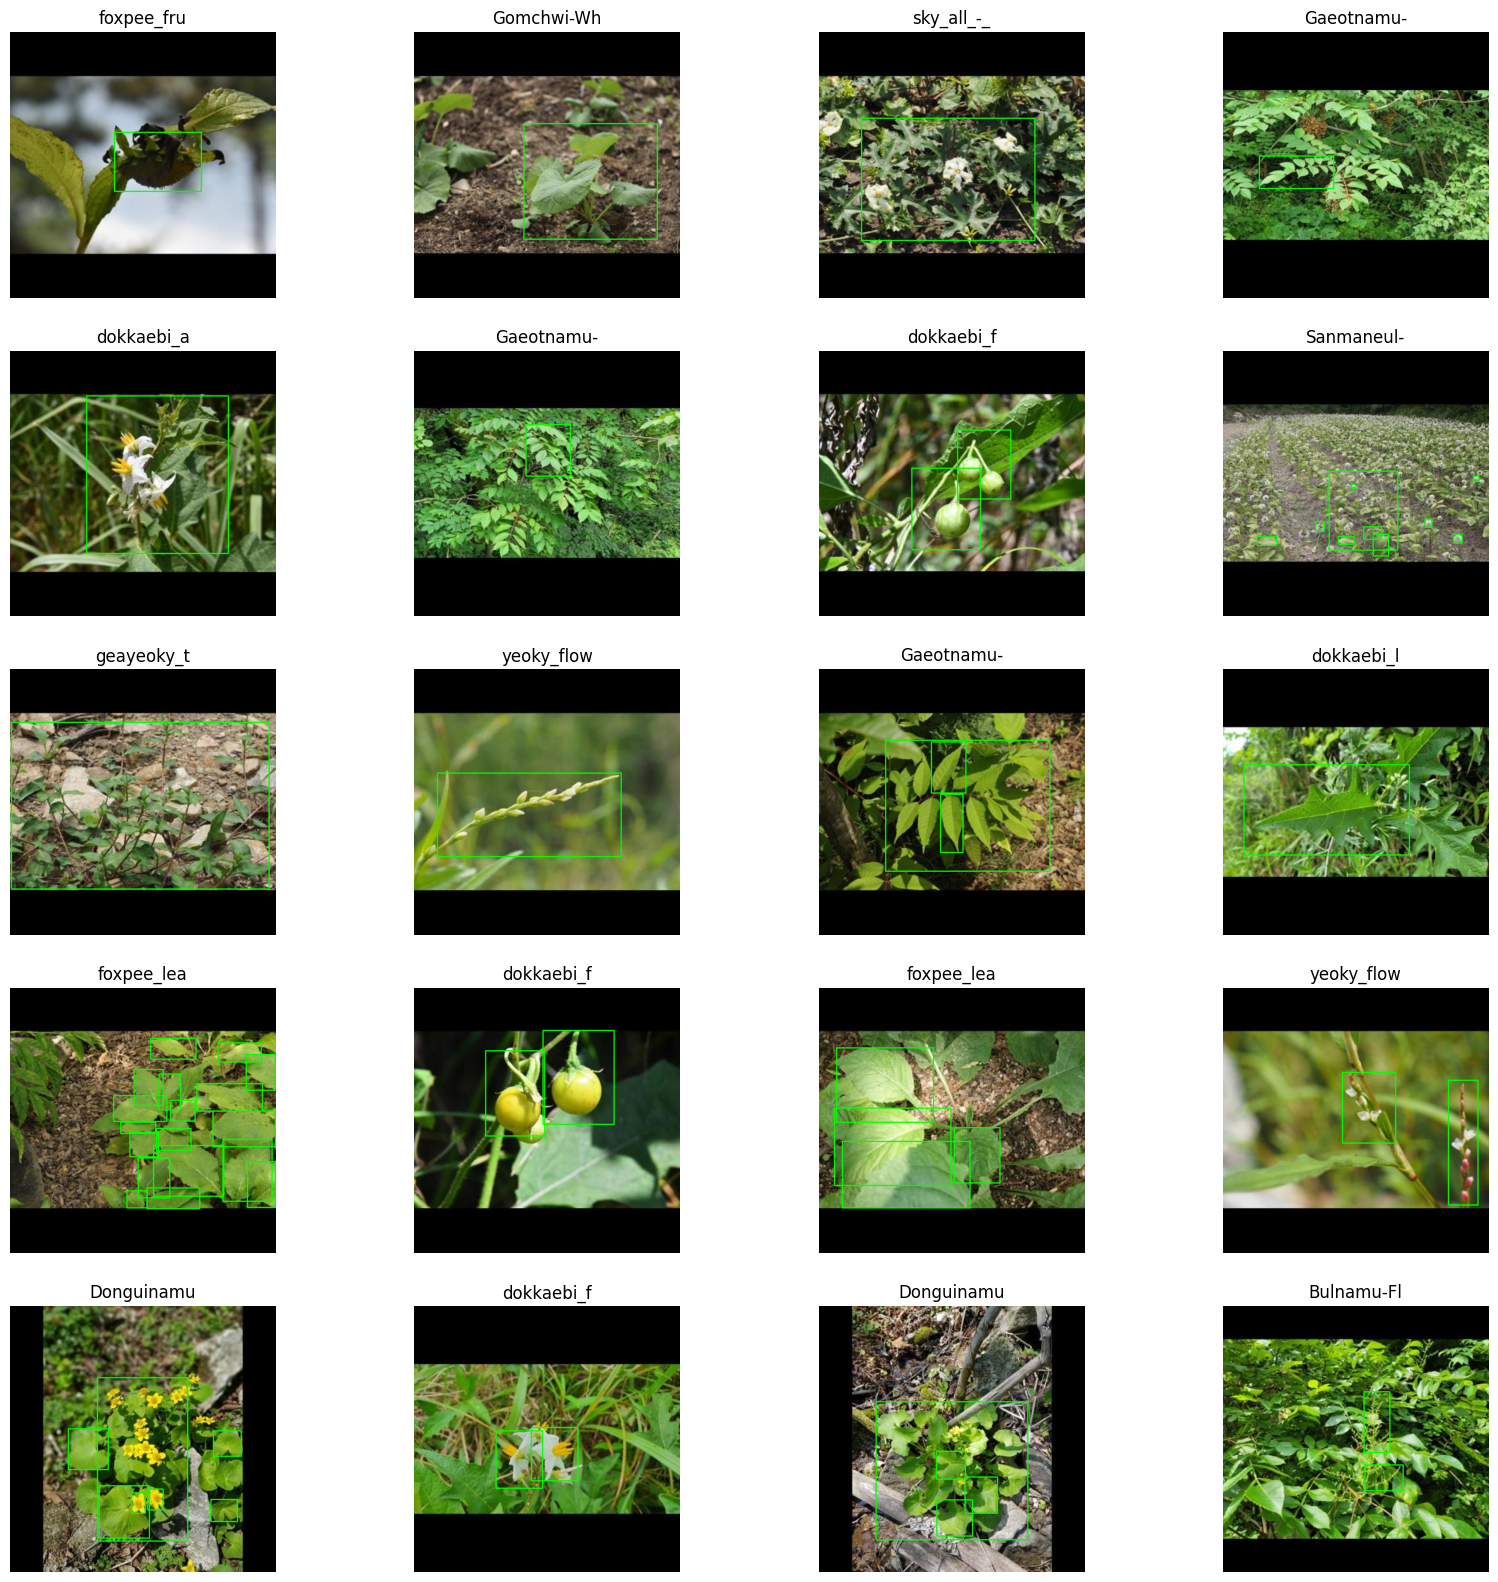

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# 경로 설정
images_folder = '/content/dataset/train/images'
labels_folder = '/content/dataset/train/labels'

# 이미지 파일 목록 불러오기
image_files = os.listdir(images_folder)

# 랜덤으로 20개의 이미지 파일 선택
random_images = random.sample(image_files, 20)

# 바운딩 박스 그리기 함수
def draw_bounding_boxes(image_path, label_path):
    # 이미지 읽기
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # YOLO 라벨 파일 읽기
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # 바운딩 박스 그리기
    for label in labels:
        label = label.strip().split()
        class_id = int(label[0])
        x_center, y_center, bbox_width, bbox_height = map(float, label[1:])

        # YOLO 형식에서 바운딩 박스를 이미지 좌표로 변환
        x_min = int((x_center - bbox_width / 2) * width)
        y_min = int((y_center - bbox_height / 2) * height)
        x_max = int((x_center + bbox_width / 2) * width)
        y_max = int((y_center + bbox_height / 2) * height)

        # 바운딩 박스 그리기 (초록색, 두께 2)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # 이미지를 BGR에서 RGB로 변환 (cv2는 BGR, matplotlib는 RGB 사용)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

# 선택된 이미지에 바운딩 박스 그리기 및 시각화
plt.figure(figsize=(20, 20))
for i, image_file in enumerate(random_images):
    image_path = os.path.join(images_folder, image_file)
    label_path = os.path.join(labels_folder, os.path.splitext(image_file)[0] + '.txt')

    # 바운딩 박스 그리기
    image_with_boxes = draw_bounding_boxes(image_path, label_path)

    # 이미지 출력
    plt.subplot(5, 4, i+1)  # 5x4 그리드로 배치
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.title(image_file[:20])

plt.show()


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.8/871.8 kB 49.1 MB/s eta 0:00:00


In [ ]:
import json

# COCO 형식의 어노테이션 JSON 파일 경로
coco_json_path = '/content/dataset/train/_annotations.coco.json'

# COCO JSON 파일 열기
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# 카테고리에서 클래스 수 구하기
categories = coco_data['categories']
class_count = len(categories)

# 클래스 이름 출력
class_names = [category['name'] for category in categories]

print(f"클래스 수: {class_count - 1}")
print(f"클래스 이름: {class_names[1:]}")


클래스 수: 82
클래스 이름: ['Bulnamu-Flower', 'Bulnamu-Fruit', 'Bulnamu-Leaf', 'Bulnamu-WholePlant', 'Dokminari-Flower', 'Dokminari-Fruit', 'Dokminari-Leaf', 'Dokminari-WholePlant', 'Donguinamul-Flower', 'Donguinamul-Leaf', 'Donguinamul-WholePlant', 'Gaeotnamu-Flower', 'Gaeotnamu-Fruit', 'Gaeotnamu-Leaf', 'Gaeotnamu-WholePlant', 'Gomchwi-Flower', 'Gomchwi-Fruit', 'Gomchwi-Leaf', 'Gomchwi-WholePlant', 'Minari-Flower', 'Minari-Fruit', 'Minari-Leaf', 'Minari-WholePlant', 'Sanmaneul-Flower', 'Sanmaneul-Leaf', 'Sanmaneul-WholePlant', 'chock_flower', 'chock_fruit', 'chock_leaf', 'chock_total', 'dakpul_all', 'dakpul_flo', 'dakpul_fruit', 'dakpul_leaf', 'dambaeful_flower', 'dambaeful_fruit', 'dambaeful_leaf', 'dambaeful_total', 'dokkaebi_all', 'dokkaebi_flower', 'dokkaebi_fruits', 'dokkaebi_leaves', 'eojeogui_all', 'eojeogui_flo', 'eojeogui_fruit', 'eojeogui_leaf', 'foxpee_all', 'foxpee_flo', 'foxpee_fruit', 'foxpee_leaf', 'gaji_all', 'gaji_flower', 'gaji_fruits', 'gaji_leaves', 'gasibak_all', 'gasibak

In [ ]:
# 필요한 라이브러리 임포트
import os

# 데이터셋 경로 설정
data_yaml_path = '/content/dataset/data.yaml'

# YOLOv8 데이터셋 정보 작성
data_yaml_content = """
train: /content/dataset/train/images
val: /content/dataset/valid/images
nc: 83
names: ['plant', 'Bulnamu-Flower', 'Bulnamu-Fruit', 'Bulnamu-Leaf', 'Bulnamu-WholePlant', 'Dokminari-Flower', 'Dokminari-Fruit', 'Dokminari-Leaf', 'Dokminari-WholePlant', 'Donguinamul-Flower', 'Donguinamul-Leaf', 'Donguinamul-WholePlant', 'Gaeotnamu-Flower', 'Gaeotnamu-Fruit', 'Gaeotnamu-Leaf', 'Gaeotnamu-WholePlant', 'Gomchwi-Flower', 'Gomchwi-Fruit', 'Gomchwi-Leaf', 'Gomchwi-WholePlant', 'Minari-Flower', 'Minari-Fruit', 'Minari-Leaf', 'Minari-WholePlant', 'Sanmaneul-Flower', 'Sanmaneul-Leaf', 'Sanmaneul-WholePlant', 'chock_flower', 'chock_fruit', 'chock_leaf', 'chock_total', 'dakpul_all', 'dakpul_flo', 'dakpul_fruit', 'dakpul_leaf', 'dambaeful_flower', 'dambaeful_fruit', 'dambaeful_leaf', 'dambaeful_total', 'dokkaebi_all', 'dokkaebi_flower', 'dokkaebi_fruits', 'dokkaebi_leaves', 'eojeogui_all', 'eojeogui_flo', 'eojeogui_fruit', 'eojeogui_leaf', 'foxpee_all', 'foxpee_flo', 'foxpee_fruit', 'foxpee_leaf', 'gaji_all', 'gaji_flower', 'gaji_fruits', 'gaji_leaves', 'gasibak_all', 'gasibak_flower', 'gasibak_fruits', 'gasibak_leaves', 'geayeoky_flower', 'geayeoky_fruit', 'geayeoky_leaf', 'geayeoky_total', 'parksay', 'parksay_flower', 'poppy', 'poppy_drug', 'sky_all', 'sky_flower', 'sky_fruits', 'sky_leaves', 'wonchuri_all', 'wonchuri_flower', 'wonchuri_fruits', 'wonchuri_leaves', 'yeoky_flower', 'yeoky_fruit', 'yeoky_leaf', 'yeoky_total', 'yeoro_all', 'yeoro_flower', 'yeoro_fruits', 'yeoro_leaves']
"""

# 파일 생성 및 내용 작성
with open(data_yaml_path, 'w') as file:
    file.write(data_yaml_content)

print(f"`data.yaml` 파일이 생성되었습니다: {data_yaml_path}")


`data.yaml` 파일이 생성되었습니다: /content/dataset/data.yaml


In [ ]:
from ultralytics import YOLO

# YOLOv8 모델
model = YOLO('yolov8l.pt')  # 모델 종류에 따라 변경 가능

# 학습 실행
model.train(
    data='/content/dataset/data.yaml',    # data.yaml 파일 경로
    epochs=100,                          # 총 학습 에폭 수
    imgsz=640,                           # 이미지 크기
    batch=16,                            # 배치 크기
    device=0,                             # GPU 장치 번호 (0이면 첫 번째 GPU 사용)
)


Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /content/dataset/train/labels.cache... 4801 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4801/4801 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/images/Donguinamul-WholePlant_-_144_jpg.rf.c24e9f5142af81de25ff9cfddebb1181.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/Donguinamul-WholePlant_-_169_png_jpg.rf.fd1c2b953b06152d67eb3725321bf72a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/Sanmaneul-WholePlant_-_132_png_jpg.rf.5846037e59e882d42a53f8f9cc6d6244.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/dambaeful_fruit_-_-_1501692_jpg.rf.e06986fc698505eb56e107d799e71dc3.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/valid/labels.cache... 1363 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1363/1363 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb2693c72e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000116, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.6G      1.675      5.782      1.916         39        640:   5%|▌         | 16/301 [00:19<05:40,  1.19s/it]


RuntimeError: DataLoader worker (pid(s) 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993) exited unexpectedly

In [ ]:
model = YOLO('/content/best.pt')  # 이전 학습 모델 불러오기

# 이어서 학습
model.train(
    data='/content/dataset/data.yaml',
    epochs=40,                  # 추가 학습할 에폭 수
    imgsz=640,
    batch=16,
    device=0
)


Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/best.pt, data=/content/dataset/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /content/dataset/train/labels.cache... 4801 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4801/4801 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/images/Donguinamul-WholePlant_-_144_jpg.rf.c24e9f5142af81de25ff9cfddebb1181.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/Donguinamul-WholePlant_-_169_png_jpg.rf.fd1c2b953b06152d67eb3725321bf72a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/Sanmaneul-WholePlant_-_132_png_jpg.rf.5846037e59e882d42a53f8f9cc6d6244.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/dambaeful_fruit_-_-_1501692_jpg.rf.e06986fc698505eb56e107d799e71dc3.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/valid/labels.cache... 1363 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1363/1363 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000115, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.8G          1      1.096      1.322          3        640: 100%|██████████| 301/301 [03:57<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:29<00:00,  1.47it/s]

                   all       1363       2996       0.62      0.661      0.664      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.3G     0.9855      1.058      1.313          2        640: 100%|██████████| 301/301 [03:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.598       0.64      0.653      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.5G      1.008      1.118      1.327          5        640: 100%|██████████| 301/301 [03:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.616      0.618      0.613      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.2G       1.01      1.136      1.331          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.631      0.604      0.609      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.5G      1.007      1.123      1.332          9        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.575      0.635       0.63      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.5G     0.9998      1.106       1.33          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.601      0.628      0.627      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.4G     0.9866      1.058      1.315          4        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.646      0.617      0.632      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.3G     0.9717      1.017      1.301          6        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.623      0.626      0.648      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.5G     0.9463     0.9844      1.288          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.632      0.627      0.655      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.4G     0.9505     0.9647      1.288          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996       0.62      0.651       0.65      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.4G     0.9385     0.9419      1.273          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.636      0.622      0.643      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.2G     0.9326     0.9311      1.271          4        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996       0.66      0.628      0.662      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.5G     0.9078     0.8725      1.254          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.642      0.662      0.671      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.4G     0.8927     0.8488      1.244          7        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.618      0.667      0.663      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.4G     0.8806     0.8436       1.23         11        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.648      0.637      0.651      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.3G      0.873     0.8245      1.237          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.629      0.641      0.652      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.5G     0.8573     0.8052      1.221          8        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.664      0.656       0.67      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.4G     0.8444     0.7943       1.22          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.611      0.656      0.647      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.4G     0.8277     0.7575      1.201          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.586      0.697      0.675      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.3G     0.8111     0.7229      1.194          4        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.635      0.662      0.664      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.5G     0.8171     0.7258      1.196          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.668      0.654      0.671      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.4G     0.7998     0.7014      1.179          4        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.624      0.687      0.675       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.4G     0.7889     0.6868      1.177          6        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.651      0.674      0.678      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.3G     0.7701     0.6807      1.165          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.649      0.663      0.673      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.4G     0.7616     0.6427      1.154          3        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.674      0.665      0.687      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.4G     0.7483     0.6402       1.14          6        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996       0.66      0.685      0.691      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.4G     0.7436     0.6291      1.139          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.619      0.695       0.67      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.3G     0.7249     0.6099      1.129          0        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.609      0.701       0.68      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.5G     0.7163     0.5908      1.124          3        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.693      0.653      0.677      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.4G     0.7013       0.58      1.117          3        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.689      0.649      0.683      0.449


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.4G     0.5973      0.426      1.061          1        640: 100%|██████████| 301/301 [03:52<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.684      0.656      0.678      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.3G     0.5744     0.3893      1.037          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.633      0.695      0.677      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.5G     0.5569     0.3636      1.024          3        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996       0.64      0.698      0.681      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.4G     0.5403     0.3562      1.008          4        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.641      0.701      0.681      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.4G     0.5279     0.3549      1.005          4        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.681       0.67      0.685      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.2G      0.517     0.3321     0.9887          2        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.686      0.667      0.684      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.5G     0.5043     0.3163     0.9819          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.669      0.676      0.686      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.4G     0.4932     0.3236     0.9777          5        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.643      0.688      0.685      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.4G     0.4851     0.3025     0.9706          1        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.58it/s]

                   all       1363       2996      0.654      0.683      0.682      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.2G     0.4744     0.3042     0.9622          5        640: 100%|██████████| 301/301 [03:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:27<00:00,  1.57it/s]

                   all       1363       2996      0.674      0.668      0.681       0.46



40 epochs completed in 2.900 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 87.8MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 87.8MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,670,601 parameters, 0 gradients, 165.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:29<00:00,  1.48it/s]


                   all       1363       2996      0.675      0.666      0.686      0.461
                 plant         20         40      0.459      0.192       0.29      0.158
        Bulnamu-Flower         20         79      0.342      0.228      0.207      0.144
         Bulnamu-Fruit         20        104      0.474      0.433       0.46      0.341
          Bulnamu-Leaf         17         17      0.339      0.176      0.216      0.083
    Bulnamu-WholePlant         20         40      0.576      0.544      0.518       0.38
      Dokminari-Flower         20         44      0.292      0.182      0.174      0.129
       Dokminari-Fruit         21         41      0.349      0.268      0.257      0.113
        Dokminari-Leaf         17         17      0.379      0.235      0.296      0.146
  Dokminari-WholePlant         15         26      0.288      0.269      0.233      0.205
    Donguinamul-Flower         27         64      0.423      0.531      0.472      0.424
      Donguinamul-Lea

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb0ccc078b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
       

In [ ]:
results = model.val(data='/content/dataset/data.yaml')  # 평가 데이터셋 경로 설정

Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/dataset/valid/labels.cache... 1363 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1363/1363 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:55<00:00,  1.56it/s]


                   all       1363       2996      0.675      0.665      0.687      0.461
                 plant         20         40      0.452      0.186       0.29      0.158
        Bulnamu-Flower         20         79      0.342      0.228      0.207      0.144
         Bulnamu-Fruit         20        104      0.476      0.433      0.461      0.343
          Bulnamu-Leaf         17         17       0.34      0.176      0.216     0.0829
    Bulnamu-WholePlant         20         40      0.576      0.544      0.518      0.378
      Dokminari-Flower         20         44      0.292      0.182      0.174       0.13
       Dokminari-Fruit         21         41      0.349      0.268      0.257      0.113
        Dokminari-Leaf         17         17      0.378      0.235      0.296      0.147
  Dokminari-WholePlant         15         26      0.288      0.269      0.233      0.205
    Donguinamul-Flower         27         64      0.423      0.531      0.472      0.423
      Donguinamul-Lea

In [ ]:
# mAP, IoU 등의 상세 지표 확인
metrics = results.box

# 지표 출력
print(f"mAP50: {metrics.map50:.4f}")          # IoU=0.5에서의 mAP
print(f"mAP50-95: {metrics.map.mean():.4f}")  # IoU=0.5:0.95에서의 mAP 평균
print(f"Mean Precision: {metrics.mp:.4f}")    # Precision 평균
print(f"Mean Recall: {metrics.mr:.4f}")       # Recall 평균


mAP50: 0.6865
mAP50-95: 0.4613
Mean Precision: 0.6749
Mean Recall: 0.6647


In [ ]:
from google.colab import files

# 폴더 압축
shutil.make_archive('/content/predict2', 'zip', '/content/runs/detect/predict2')

# ZIP 파일 다운로드
files.download('/content/predict2.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>